### Modified by Brian Rose

to use [intake-esm](https://intake-esm.readthedocs.io/en/latest/) for the data ingestion step (and hopefully be a bit more explicit and easier to generalize to other data)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
# Cluster was created via the dask labextension
# Delete this cell and replace with a new one

# from dask.distributed import Client
# from dask_kubernetes import KubeCluster

# cluster = KubeCluster()
# cluster.adapt(minimum=1, maximum=20, interval='2s')
# client = Client(cluster)
# client

In [3]:
#  Here we will work with surface air temperature
varname = 'tas'

In [4]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28660 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28660 zstore(s)

	> 59 dcpp_init_year(s)

## The task at hand

- Loop through the `source_id` for `experiment_id == 'historical'`
- For each model:
    - select only a single ensemble member (at least for now)
    - Take a slice `time=slice('1981', '2010')` and compute time average over that slice (date range consistent with the long-term climatology of the NCEP reanalysis, to which we are comparing
    - Regrid the `tas` data to a common grid
    - drop redundant variables (like "height: 2m")
    - concatenate to ensemble dataset along `ensemble` dimension

In [5]:
#  Define the common target grid axes
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-88.5, 89.5, 2.)),
                     'lon': (['lon'], np.arange(0.5, 360., 2.)),
                    }
                   )

def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [6]:
cat = col.search(experiment_id='historical', 
                 table_id='Amon', 
                 variable_id=varname,
                 member_id='r1i1p1f1'  # choose first ensemble member only (for now)
                )
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
289,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i...,NaN
552,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/BCC/BCC-ESM1/historical/r1i1p1...,NaN
827,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/CAMS/CAMS-CSM1-0/historical/r1...,NaN
2446,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/CCCma/CanESM5/historical/r1i1p...,NaN
5745,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/E3SM-Project/E3SM-1-0/historic...,NaN
5999,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-...,NaN
7339,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN
9575,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1...,NaN
11166,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MRI/MRI-ESM2-0/historical/r1i1...,NaN
11465,CMIP,NASA-GISS,GISS-E2-1-G-CC,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NASA-GISS/GISS-E2-1-G-CC/histo...,NaN


### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [7]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 19 group(s)


In [8]:
ds = dset_dict['CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn']
if ('longitude' in ds.dims) and ('latitude' in ds.dims):
    ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
ds = xr.decode_cf(ds)  # ensures that time is consistent across each dataset

In [9]:
ensdict = {}
for key, ds in tqdm(dset_dict.items()):
    print(key)
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
    ds = xr.decode_cf(ds)
    # take 1980-2019 mean
    timeave = ds.sel(time=slice('1981', '2010')).mean(dim='time')  # date range consistent with reanalysis long-term-mean
    # regrid to common 1deg by 1deg grid
    ds_new = regrid_to_common(timeave[varname], ds_out)
    ds_new.attrs['name'] = ds.attrs['source_id']
    # drop redundant variables (like "height: 2m")
    for coord in ds_new.coords:
        if coord not in ['lat','lon']:
            ds_new = ds_new.drop(coord)
    # Add ensemble as new dimension
    ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)
    ensdict[key] = ds_new  # add this to the dictionary

CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
Reuse existing file: bilinear_160x320_89x180_peri.nc
CMIP.BCC.BCC-ESM1.historical.Amon.gn
Reuse existing file: bilinear_64x128_89x180_peri.nc
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
Reuse existing file: bilinear_160x320_89x180_peri.nc
CMIP.CCCma.CanESM5.historical.Amon.gn
Reuse existing file: bilinear_64x128_89x180_peri.nc
CMIP.E3SM-Project.E3SM-1-0.historical.Amon.gr
Reuse existing file: bilinear_180x360_89x180_peri.nc
CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Amon.gr
Reuse existing file: bilinear_256x512_89x180_peri.nc
CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr
Reuse existing file: bilinear_143x144_89x180_peri.nc
CMIP.MIROC.MIROC6.historical.Amon.gn
Reuse existing file: bilinear_128x256_89x180_peri.nc
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn
Reuse existing file: bilinear_160x320_89x180_peri.nc
CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn
Reuse existing file: bilinear_90x144_89x180_peri.nc
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn


In [10]:
ens = xr.concat([ds for name, ds in ensdict.items()], dim='ensemble')

## Some data to compare against!

We will use long-term mean climatology from NCEP reanalysis (because it's easy)

In [11]:
# Long-term mean 1981-2010
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "surface/air.mon.ltm.nc")
obs_native = ncep_air.air.mean(dim='time')
# regrid to common 1deg by 1deg grid (AND CONVERT TO KELVIN)
obs = regrid_to_common(obs_native + 273.15, ds_out)
obs.attrs.update(ncep_air.attrs)  # keep all the original attributes
obs

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_73x144_89x180_peri.nc


<xarray.DataArray 'air' (lat: 89, lon: 180)>
array([[227.87071775, 227.77867669, 227.69558013, ..., 228.19172488,
        228.07723308, 227.97025906],
       [228.24883121, 228.13882224, 228.05230119, ..., 228.72735529,
        228.54016312, 228.38161397],
       [228.71559934, 228.65050634, 228.62540467, ..., 229.23339455,
        228.99685167, 228.82751383],
       ...,
       [257.77572112, 258.07569418, 258.35354337, ..., 256.82928191,
        257.14759714, 257.46473238],
       [256.34238096, 256.47727477, 256.6110431 , ..., 255.95488213,
        256.07944782, 256.20916526],
       [256.08768962, 256.10848999, 256.12928397, ..., 256.02687154,
        256.04691442, 256.06719787]])
Coordinates:
  * lon      (lon) float64 0.5 2.5 4.5 6.5 8.5 ... 350.5 352.5 354.5 356.5 358.5
  * lat      (lat) float64 -88.5 -86.5 -84.5 -82.5 -80.5 ... 81.5 83.5 85.5 87.5
Attributes:
    regrid_method:                  bilinear
    description:                    Data from NCEP initialized reanalysis 

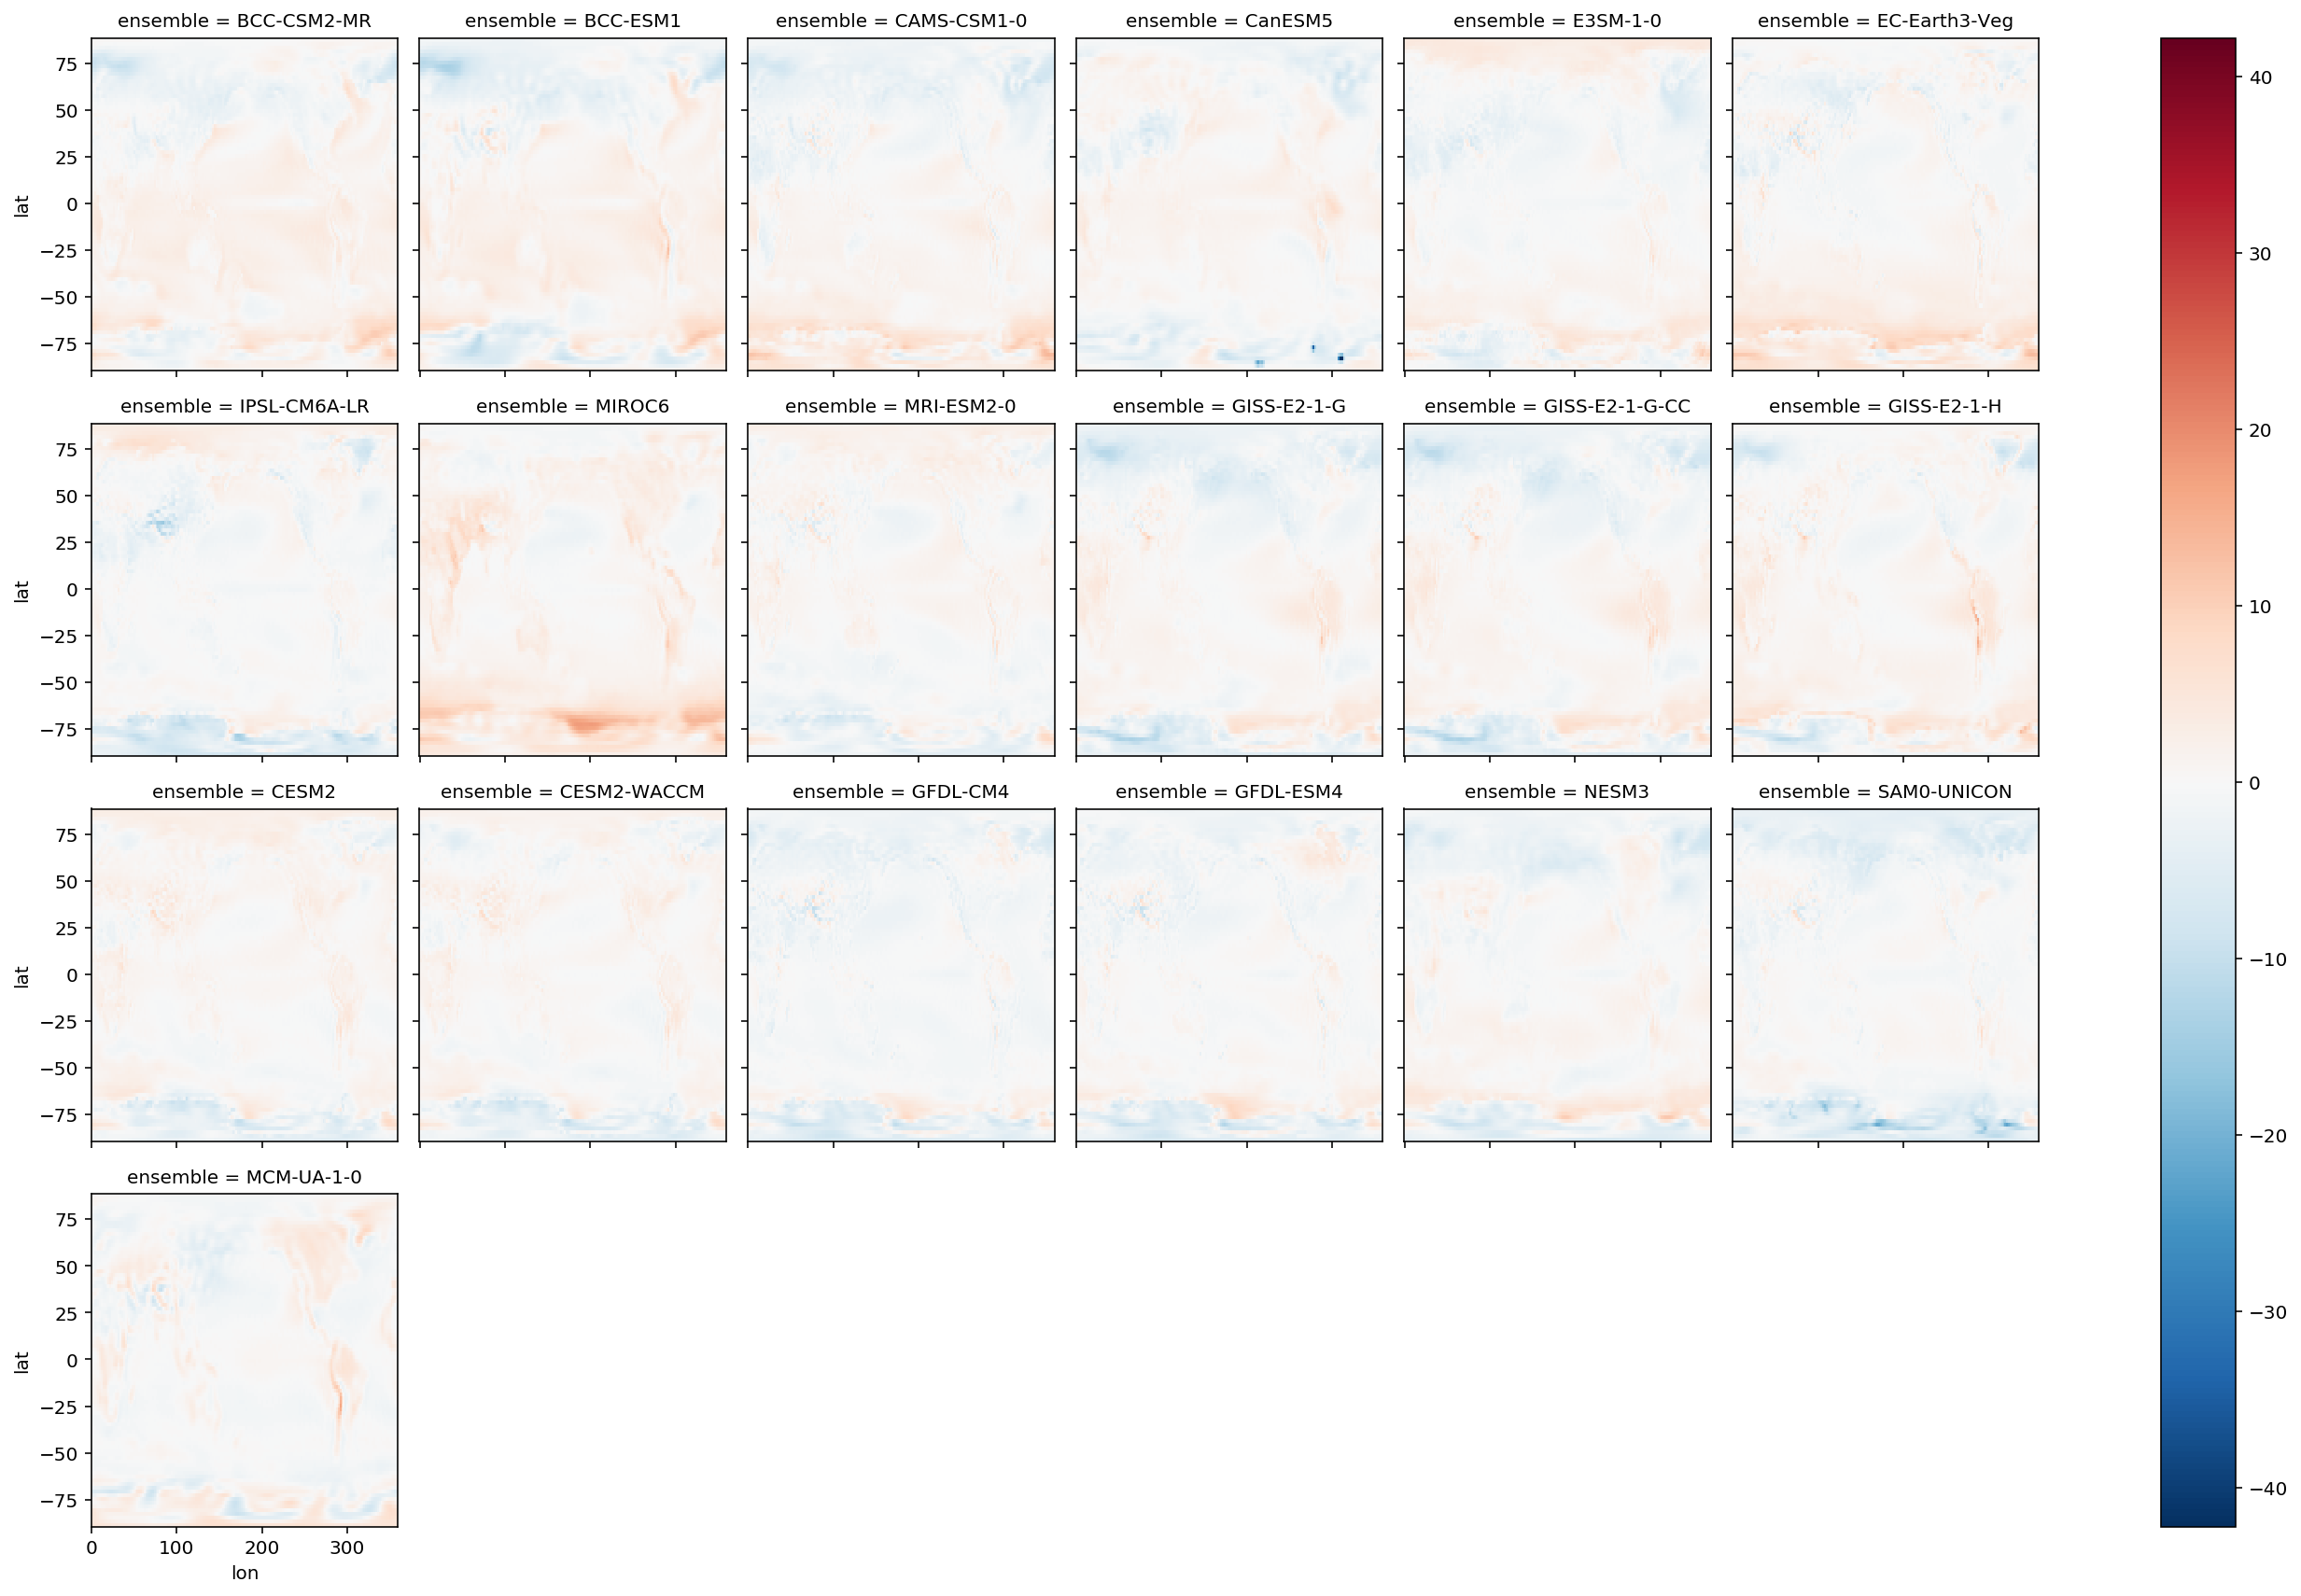

In [12]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q = (ens-obs).plot(x='lon', y='lat', col='ensemble', col_wrap=6)
# How to change color bar limits?

In [13]:
# Calculate skill of each model run relative to observations
# Note: currently the multi-model mean is a temporary stand-in for observations.
ens.attrs['rmse'] = {}
ens.attrs['mae'] = {}
for ensemble in tqdm(ens.ensemble):
    ds = ens.sel(ensemble=ensemble)
    ens.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs, ds, ['lat', 'lon']).values
    ens.attrs['mae'][str(ensemble.values)] = xs.mae(obs, ds, ['lat', 'lon']).values
ens.attrs

{'regrid_method': 'bilinear',
 'rmse': {'BCC-CSM2-MR': array([2.40455836]),
  'BCC-ESM1': array([2.92021978]),
  'CAMS-CSM1-0': array([2.61053591]),
  'CanESM5': array([2.02221662]),
  'E3SM-1-0': array([1.98994461]),
  'EC-Earth3-Veg': array([2.64798594]),
  'IPSL-CM6A-LR': array([2.38362787]),
  'MIROC6': array([3.41329651]),
  'MRI-ESM2-0': array([1.6824225]),
  'GISS-E2-1-G': array([2.63061602]),
  'GISS-E2-1-G-CC': array([2.5871907]),
  'GISS-E2-1-H': array([2.28980276]),
  'CESM2': array([1.85648285]),
  'CESM2-WACCM': array([1.79884706]),
  'GFDL-CM4': array([2.0967786]),
  'GFDL-ESM4': array([2.02785985]),
  'NESM3': array([2.26471255]),
  'SAM0-UNICON': array([2.79110441]),
  'MCM-UA-1-0': array([2.06197673])},
 'mae': {'BCC-CSM2-MR': array([1.88715821]),
  'BCC-ESM1': array([2.27086843]),
  'CAMS-CSM1-0': array([1.93105748]),
  'CanESM5': array([1.40301768]),
  'E3SM-1-0': array([1.479321]),
  'EC-Earth3-Veg': array([1.84881775]),
  'IPSL-CM6A-LR': array([1.48887355]),
  'MIR

(0, 4.25)

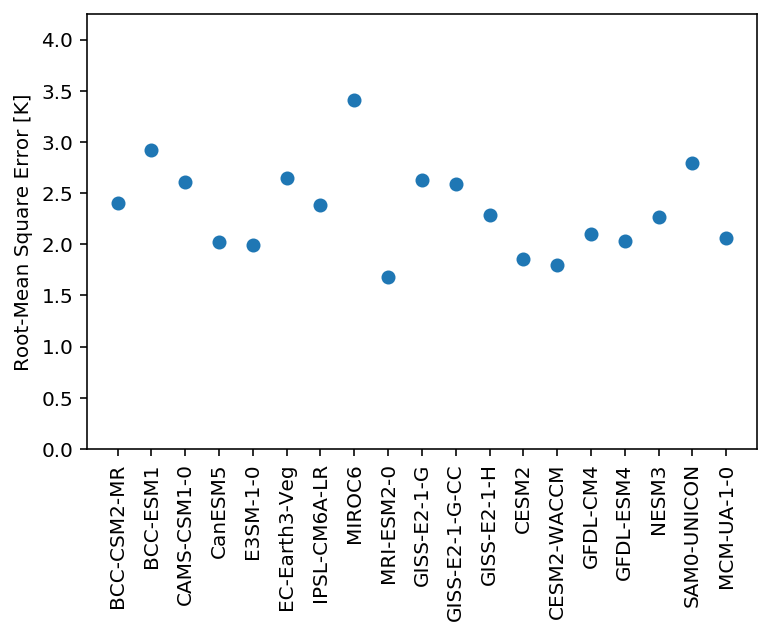

In [14]:
plt.plot(list(ens.attrs['rmse'].values()),'C0o')
plt.xticks(np.arange(len(ens.attrs['rmse'].keys())),list(ens.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Root-Mean Square Error [K]')
plt.ylim([0,4.25])